## testing several models for both the SeaFlow and Zinser (updated) datasets
 * modified from 2020-03-30 notebook with updated data processing
 * at this point still using old observation misfit formulation, next notebook will assess impact of that

### load data from files and plot

In [1]:
#%matplotlib notebook
import netCDF4 as nc4
import numpy as np

# load data
datafiles = {
    'seaflow':'data/SeaFlow_SizeDist_regrid-25-8.nc',
    'zinser':'data/Zinser_SizeDist_calibrated-26-6.nc',
}

itestfiles = {
    'seaflow':'data/Zinser_SizeDist_calibrated-26-6-itest.csv', # same as zinser
    'zinser':'data/Zinser_SizeDist_calibrated-26-6-itest.csv',         
}

desc = {
    'seaflow':'SeaFlow dataset',
    'zinser':'Zinser dataset',    
}

data_gridded = {}
for k in datafiles:
    data_gridded[k] = {}
    with nc4.Dataset(datafiles[k]) as nc:
        for var in nc.variables:
            data_gridded[k][var] = nc.variables[var][:]
    desc[k] += ' (m={data[m]}, $\Delta_v^{{-1}}$={data[delta_v_inv]})'.format(data=data_gridded[k])

data_gridded[k]['PAR'] *= 200.0/22.0 # make light similar for this experiment (it is later normalized by E_star) 

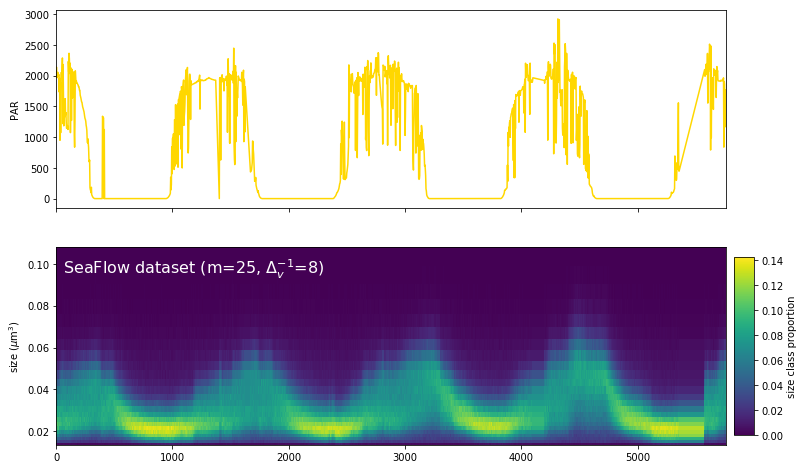

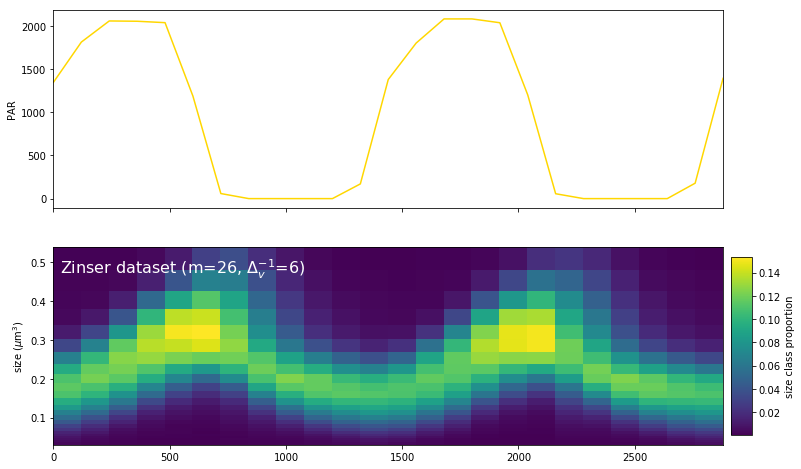

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

for i,k in enumerate(data_gridded):
    nrows = 2
    fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))

    ax = axs[0]
    ax.plot(data_gridded[k]['time'], data_gridded[k]['PAR'], color='gold')
    ax.set(ylabel='PAR')

    v_min = data_gridded[k]['v_min']
    delta_v = 1.0/data_gridded[k]['delta_v_inv']
    v = v_min * 2**(np.arange(data_gridded[k]['m'])*delta_v) 
    
    ax = axs[1]
    pc = ax.pcolormesh(data_gridded[k]['time'],v,data_gridded[k]['w_obs'])
    ax.set(ylabel='size ($\mu$m$^3$)')
    ax.text(0.01, 0.95, desc[k], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
axs[-1].set_xlabel=('time (minutes)')
None

### process data and plot it

In [3]:
# prepare data for Stan model

data = {}
mcmcs = {}
models = {}

In [4]:
for k in data_gridded:
    dt = 20 # in units of minutes
    
    data[k] = {'dt':dt}
    for v in ('m','v_min','delta_v_inv'):
        data[k][v] = data_gridded[k][v]

    if 'seaflow' in k:
        limit_days = 1
        
        # new: average SeaFlow data in hourly bins
        binsize = 60 # in minutes
        numbins = int(np.ceil(data_gridded[k]['time'][-1]/binsize))
        
        data[k]['obs'] = np.full((data[k]['m'],numbins), fill_value=np.nan)
        data[k]['t_obs'] = np.full(numbins, fill_value=np.nan)
        
        i = 0
        for ibin in range(numbins):
            binind = np.logical_and(data_gridded[k]['time'] >= ibin*binsize,
                                    data_gridded[k]['time'] < (ibin+1)*binsize)
            if np.any(binind):
                # TODO we may want to make this a sum when dealing with counts
                data[k]['obs'][:,i] = np.mean(data_gridded[k]['w_obs'][:,binind], axis=1)
                data[k]['t_obs'][i] = (ibin+0.5) * binsize
                i += 1
        
        data[k]['obs'] = data[k]['obs'][:,:i]
        data[k]['t_obs'] = data[k]['t_obs'][:i]
        
        # median filter PAR
        # see: medianfilter_par.ipynb
        n = len(data_gridded[k]['PAR'])
        wsh = 30 # half of median filter window size; window size is 2*wsh+1
        par = np.array([np.median(data_gridded[k]['PAR'][max(0,i-wsh):min(n,i+wsh+1)]) for i in range(n)])
    else:
        limit_days = 2
        
        data[k]['obs'] = data_gridded[k]['w_obs']
        data[k]['t_obs'] = data_gridded[k]['time']
        par = data_gridded[k]['PAR']
        
    if limit_days > 0:
        limit_minutes = limit_days*1440
        
        ind_obs = data[k]['t_obs'] < limit_minutes
        data[k]['t_obs'] = data[k]['t_obs'][ind_obs]
        data[k]['obs'] = data[k]['obs'][:,ind_obs]
        
        data[k]['nt'] = int(limit_minutes//data[k]['dt'])

    data[k]['nt_obs'] = data[k]['t_obs'].size
    
    # load cross-validation testing indices and add them to data
    data[k]['i_test'] = np.loadtxt(itestfiles[k]).astype(int)
    # remove last index, so that dimensions agree
    data[k]['i_test'] = data[k]['i_test'][:-1]
    
    # finally, add light data
    t = np.arange(data[k]['nt'])*data[k]['dt']
    data[k]['E'] = np.interp(t, xp=data_gridded[k]['time'], fp=par)
    
    # consistency check
    if len(data[k]['i_test']) != data[k]['nt_obs']:
        raise ValueError('Invalid number of testing indices for "{}" (expected {}, got {}).'.format(k,data[k]['nt_obs'],len(data[k]['i_test'])))

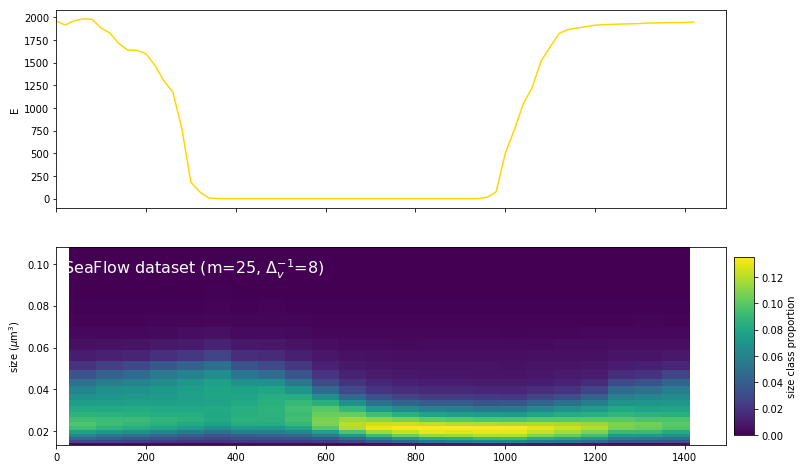

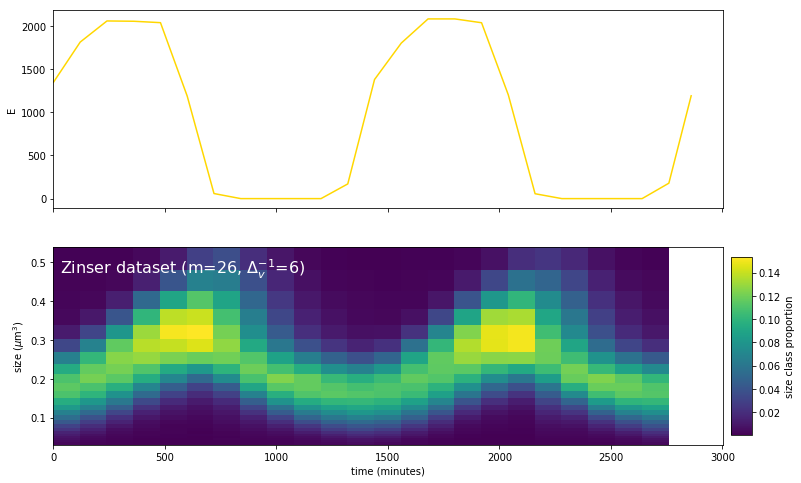

In [5]:
for i,k in enumerate(data):
    nrows = 2
    fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))

    ax = axs[0]
    t = np.arange(data[k]['nt'])*data[k]['dt']
    ax.plot(t, data[k]['E'], color='gold')
    ax.set(ylabel='E')

    v_min = data[k]['v_min']
    delta_v = 1.0/data[k]['delta_v_inv']
    v = v_min * 2**(np.arange(data[k]['m'])*delta_v) 
    
    ax = axs[1]
    pc = ax.pcolormesh(data[k]['t_obs'],v,data[k]['obs'])
    ax.set(ylabel='size ($\mu$m$^3$)')
    ax.text(0.01, 0.95, desc[k], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
    ax.set_xlim(left=0.0)
axs[-1].set_xlabel('time (minutes)')

None

# The model

modified from *Sosik et al. (2003), Growth rates of coastal phytoplankton from time-series measurements with a submersible flow cytometer, Limnol. Oceanogr.*

In [6]:
import pystan
refit_all = False
refit_required = {}

modelfiles = {
    'freedelta_respv2_lightsig':'stancode/matrixmodel_estinilnorm_freedelta-lightsig_respv2_normparam_trackgrowth_xval.stan',
    'freedelta_respiv2_lightsig':'stancode/matrixmodel_estinilnorm_freedelta-lightsig_respiv2_normparam_trackgrowth_xval.stan',
    'freedelta_respiv2':'stancode/matrixmodel_estinilnorm_freedelta_respiv2_normparam_trackgrowth_xval.stan',
}
desc_model = {
    'freedelta_respv2_lightsig':'model with respiration v2, "free" deltas, light-dep div',
    'freedelta_respiv2_lightsig':'model with size-dep respiration v2, "free" deltas, light-dep div',
    'freedelta_respiv2':'model with size-dep respiration v2, "free" deltas',
}

for name in modelfiles:
    with open(modelfiles[name]) as f: 
        stan_code = f.read()
    refit_required[name] = True
    if name in models and models[name].model_code == stan_code:
        print('{}: unchanged code, not recompiling'.format(name))
        refit_required[name] = False
    else:
        if name in models:
            print('{}: code change detected, recompiling'.format(name))
        else:
            print('{}: compiling'.format(name))
        models[name] = pystan.StanModel(file=modelfiles[name], model_name=name, obfuscate_model_name=False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL freedelta_respv2_lightsig NOW.


freedelta_respv2_lightsig: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL freedelta_respiv2_lightsig NOW.


freedelta_respiv2_lightsig: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL freedelta_respiv2 NOW.


freedelta_respiv2: compiling


In [7]:
# run a bunch of experiments -- this may take a while
for name in models:
    for k in data:
        if name in mcmcs:
            if k in mcmcs[name] and not refit_all and not refit_required[name]:
                print('{} ({})'.format(name, desc_model[name])) 
                print('\n'.join(x for x in mcmcs[name][k].__str__().split('\n') if 'mod_obspos' not in x))
                continue
        else:
            mcmcs[name] = {}
        for itry in range(3):
            mcmcs[name][k] = models[name].sampling(data=data[k], iter=2000)
            # get max Rhat
            s = mcmcs[name][k].summary()
            irhat = s['summary_colnames'].index("Rhat")
            rhats = s['summary'][:,irhat]
            rhat_max = np.nanmax(rhats)
            if rhat_max < 1.1:
                break
            print('{}: in try {}/3 found Rhat={:.3f}, trying again'.format(name,itry+1,rhat_max))
        print('{} ({})'.format(name, desc_model[name])) 
        print('\n'.join(x for x in mcmcs[name][k].__str__().split('\n') if 'mod_obspos' not in x))

freedelta_respv2_lightsig (model with respiration v2, "free" deltas, light-dep div)
Inference for Stan model: freedelta_respv2_lightsig.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean      sd    2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_mu            2.79    0.02    0.58    1.74   2.38   2.74   3.17   4.02    721    1.0
delta_sigma         1.66    0.02    0.53    0.88   1.29   1.57   1.92   2.99    498    1.0
delta_max[1]        0.15  3.9e-3    0.14  4.7e-3   0.05   0.12   0.22   0.51   1269    1.0
delta_max[2]        0.57    0.01    0.31    0.07   0.33   0.56    0.8   1.21    680    1.0
delta_max[3]        1.22    0.02    0.45    0.32   0.92   1.24   1.53   2.08    873    1.0
delta_max[4]        1.92    0.02    0.65    0.72   1.47   1.91   2.34   3.22    992    1.0
delta_max[5]        2.51    0.03    0.84     1.0   1.93   2.47   3.06   4.32    950    1.0
delta_max[6]     

freedelta_respv2_lightsig: in try 1/3 found Rhat=1.336, trying again


freedelta_respv2_lightsig: in try 2/3 found Rhat=1.325, trying again


freedelta_respv2_lightsig (model with respiration v2, "free" deltas, light-dep div)
Inference for Stan model: freedelta_respv2_lightsig.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
delta_mu             1.49    0.06     0.5    0.63    1.12    1.47    1.82    2.52     73   1.05
delta_sigma          1.67    0.07    0.43    1.01    1.34    1.61    1.92     2.7     44   1.07
delta_max[1]         1.04    0.06    0.87    0.05    0.38    0.81    1.44    3.24    206   1.02
delta_max[2]         0.87    0.05    0.81    0.02    0.26    0.66    1.21    3.01    323   1.01
delta_max[3]         0.62    0.04    0.57    0.03     0.2    0.47    0.88     2.2    269   1.01
delta_max[4]         0.42    0.03    0.43    0.02    0.12    0.28    0.56    1.58    190   1.01
delta_max[5]         0.33    0.02     0.3    0.01     0.1    0.25    0.47

freedelta_respiv2_lightsig (model with size-dep respiration v2, "free" deltas, light-dep div)
Inference for Stan model: freedelta_respiv2_lightsig.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean      sd    2.5%    25%    50%     75%   97.5%  n_eff   Rhat
delta_mu             2.87    0.03     0.6    1.74   2.43   2.84    3.28    4.06    570    1.0
delta_sigma          1.84    0.03    0.59    0.94   1.42   1.73    2.17    3.26    428   1.01
delta_max[1]         0.12  3.0e-3    0.11  2.3e-3   0.04   0.09    0.17    0.39   1211    1.0
delta_max[2]         0.43    0.01    0.29    0.02   0.19   0.41    0.62    1.05    450   1.01
delta_max[3]         1.04    0.02    0.45    0.19   0.72   1.03    1.34    1.94    772    1.0
delta_max[4]         1.65    0.03     0.7    0.39   1.14   1.62    2.11    3.13    493   1.01
delta_max[5]         2.28    0.03    0.86    0.68   1.68   2.23    2.85    4

freedelta_respiv2_lightsig: in try 1/3 found Rhat=1.131, trying again


freedelta_respiv2_lightsig: in try 2/3 found Rhat=1.109, trying again


freedelta_respiv2_lightsig: in try 3/3 found Rhat=1.158, trying again
freedelta_respiv2_lightsig (model with size-dep respiration v2, "free" deltas, light-dep div)
Inference for Stan model: freedelta_respiv2_lightsig.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
delta_mu             1.78    0.09    0.49    0.91    1.44    1.77     2.1    2.79     33    1.1
delta_sigma          1.94    0.08    0.42    1.22    1.64     1.9    2.18    2.91     25   1.09
delta_max[1]         1.14    0.08    0.98    0.04    0.42    0.86    1.55    3.69    155   1.03
delta_max[2]         0.86    0.05    0.79    0.02    0.29    0.66    1.21    2.92    296   1.01
delta_max[3]         0.57    0.05    0.57    0.01    0.15    0.39    0.81     2.1    149   1.04
delta_max[4]         0.43    0.02     0.4    0.02    0.15    0.33    0.56    1.51    294

freedelta_respiv2: in try 1/3 found Rhat=3.564, trying again
freedelta_respiv2 (model with size-dep respiration v2, "free" deltas)
Inference for Stan model: freedelta_respiv2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
delta_mu             1.49    0.01    0.46    0.71    1.17    1.45    1.77    2.52   1792    1.0
delta_sigma          1.86    0.01    0.48    1.11    1.52     1.8    2.13    3.01   1761    1.0
delta_max[1]          0.7  9.6e-3    0.59    0.03    0.26    0.55    0.98    2.22   3837    1.0
delta_max[2]         0.48  7.4e-3    0.43  9.7e-3    0.15    0.37    0.67    1.61   3447    1.0
delta_max[3]         0.33  4.5e-3    0.31    0.01    0.11    0.24    0.47    1.18   4734    1.0
delta_max[4]         0.25  3.4e-3    0.23  6.6e-3    0.07    0.18    0.36    0.83   4532    1.0
delta_max[5]         0.19  2.6e-3 

## Plot the results

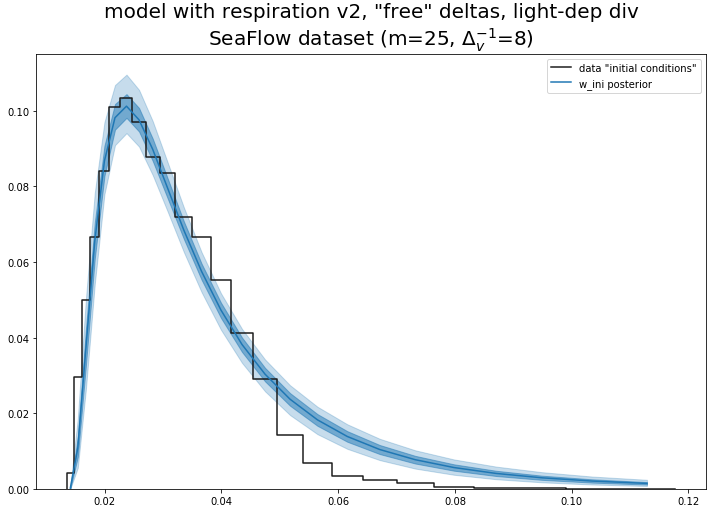

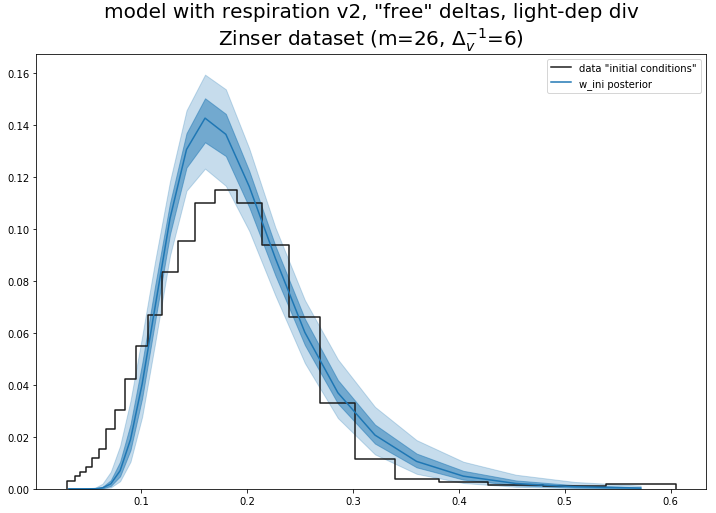

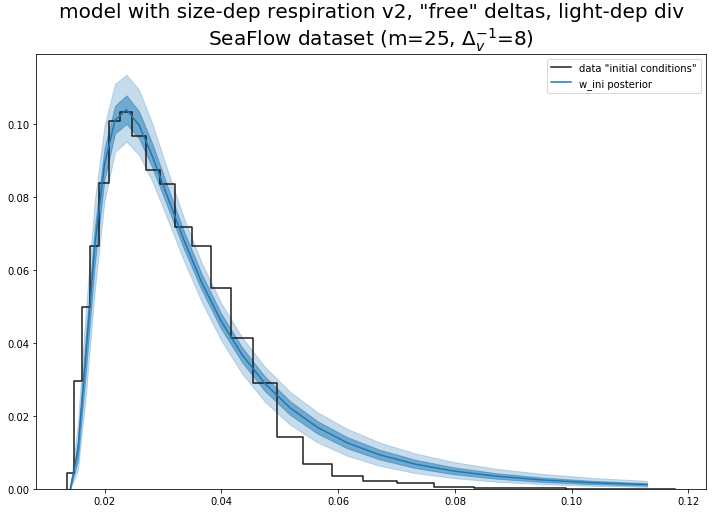

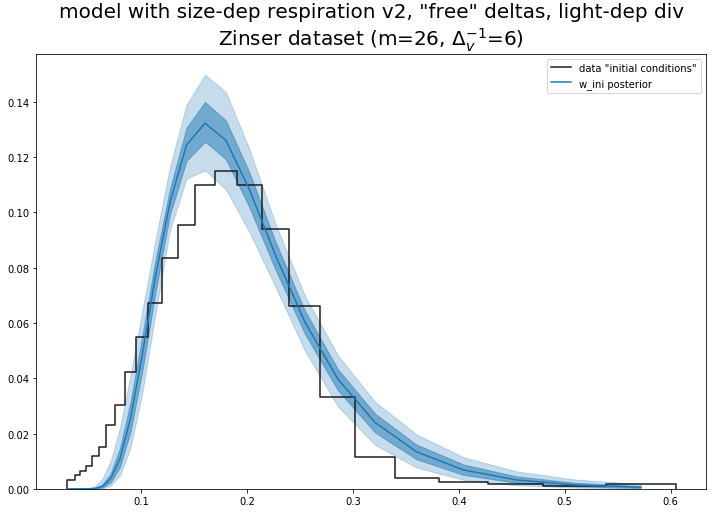

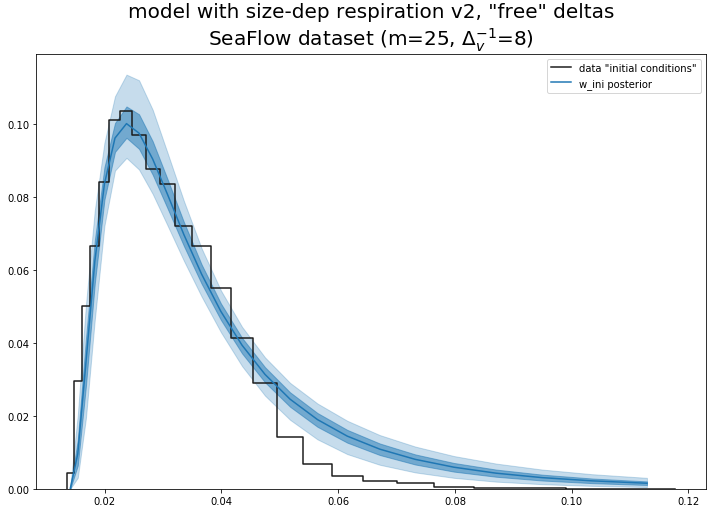

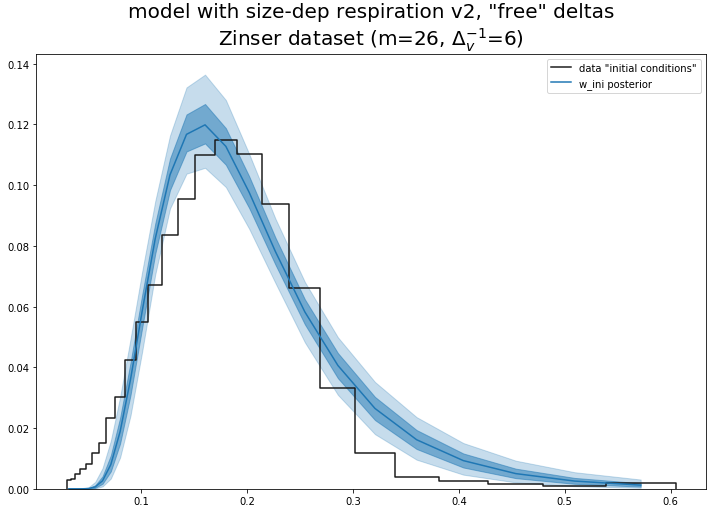

In [8]:
for name in mcmcs:
    for k in data:
        mcmc = mcmcs[name][k]
        if 'w_ini[1]' in mcmc.flatnames:
            fig, ax = plt.subplots(figsize=(12,8))
            ax.set_title('{}\n{}'.format(desc_model[name],desc[k]), size=20)

            plotdata_y = np.zeros(2*(data_gridded[k]['m']+1))

            delta_v = 1.0/data_gridded[k]['delta_v_inv']
            v_ext = data_gridded[k]['v_min'] * 2**(np.arange(data_gridded[k]['m']+1)*delta_v)
            v = v_ext[:-1]
            v_width = v_ext[1:] - v_ext[:-1]

            v_mid = 0.5*(v_ext[1:]+v_ext[:-1])

            cdata = data_gridded[k]['w_obs'][:,0]
            plotdata_y[1:-1] = np.repeat(cdata,2)

            ax.plot(np.repeat(v_ext,2), plotdata_y, color='0.1', label='data "initial conditions"')

            quantiles = np.percentile(mcmc['w_ini'], (5,25,50,75,95), axis=0)

            ax.fill_between(v_mid, quantiles[0,:], quantiles[-1,:], color='C0', alpha=0.25)
            ax.fill_between(v_mid, quantiles[1,:], quantiles[-2,:], color='C0', alpha=0.5)
            ax.plot(v_mid, quantiles[2,:], color='C0', label='w_ini posterior')

            ax.set_ylim(bottom=0.0)
            ax.legend()
None

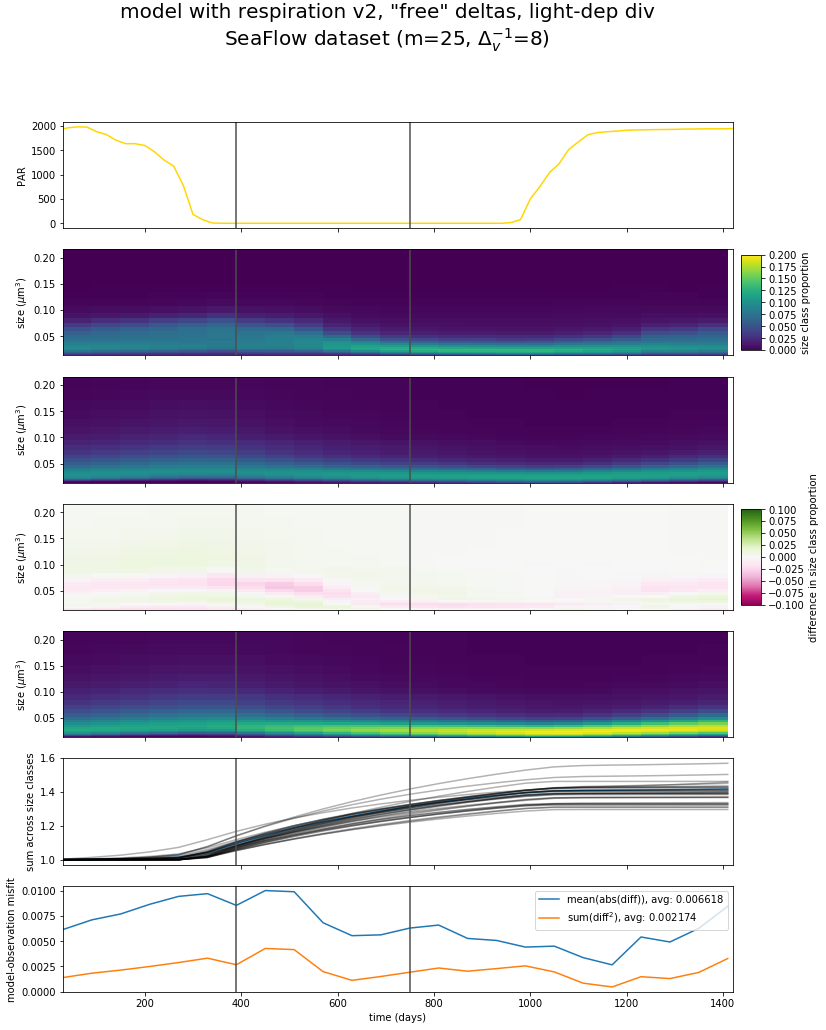

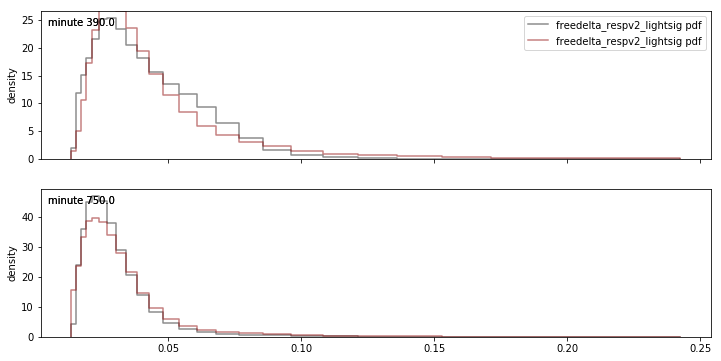

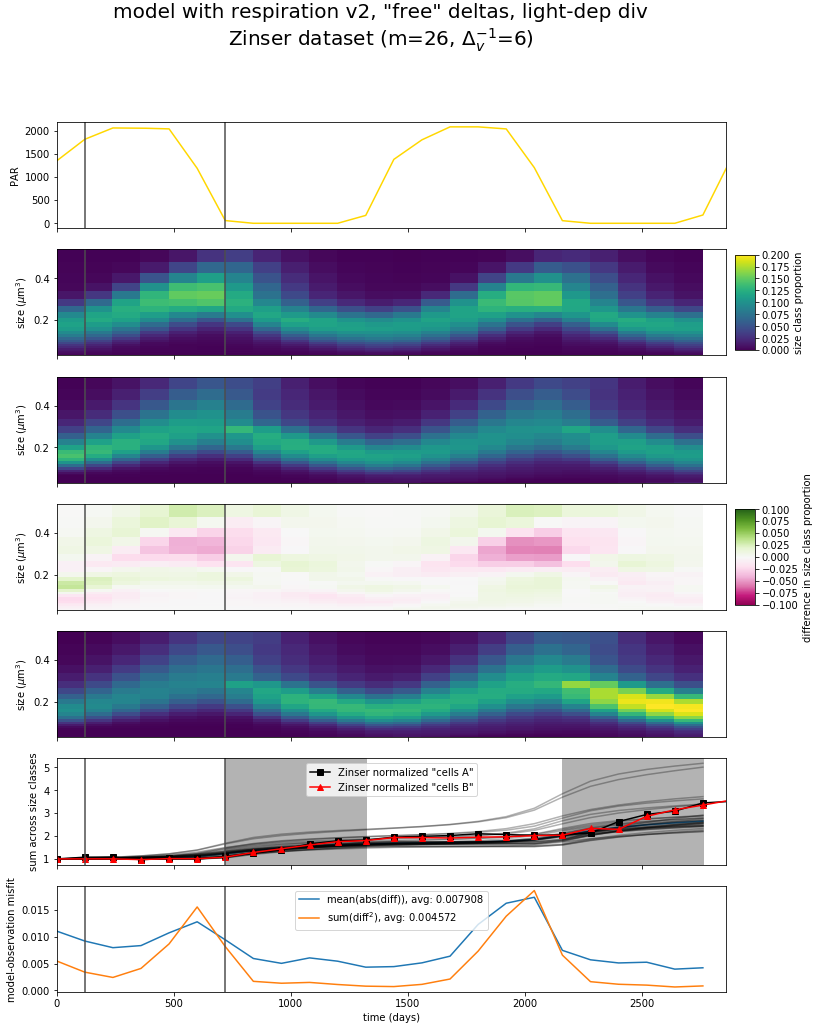

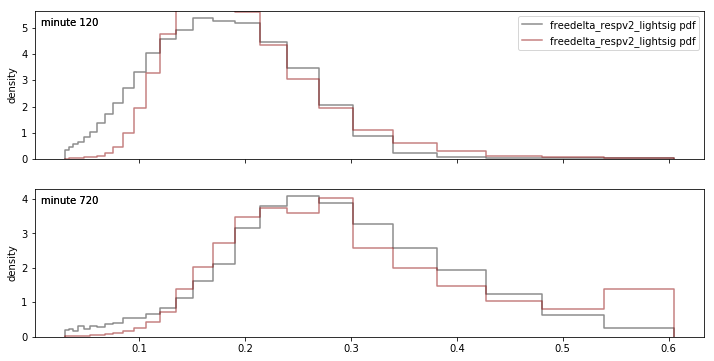

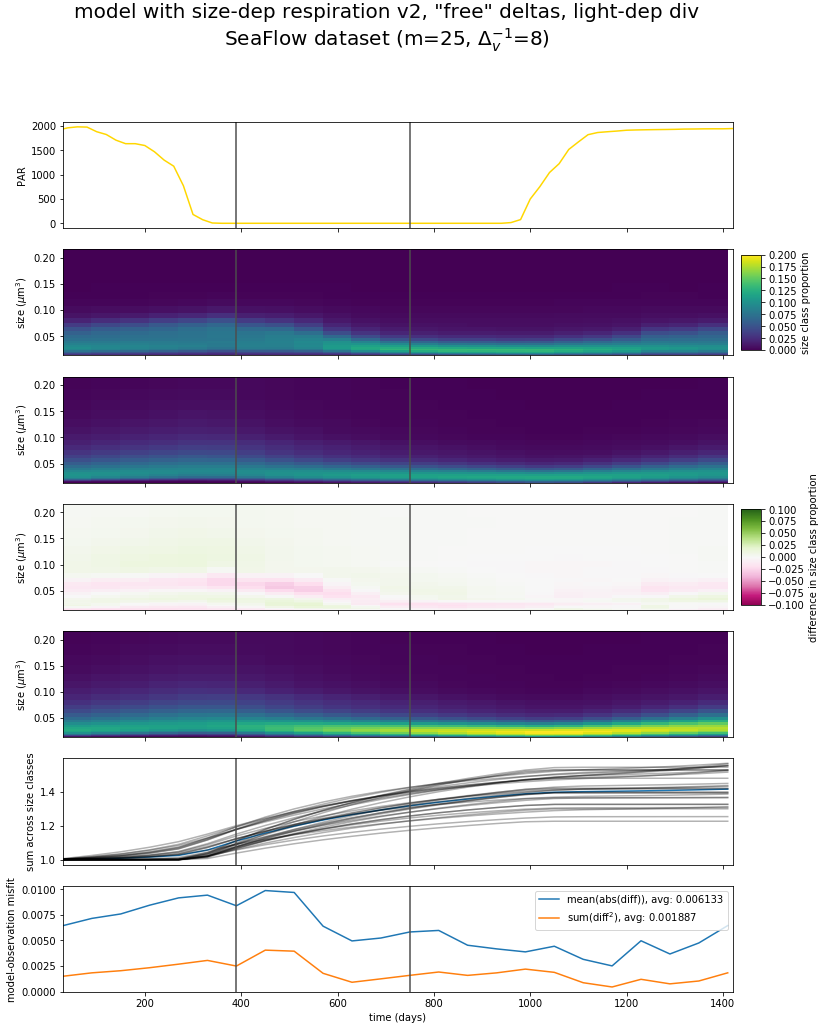

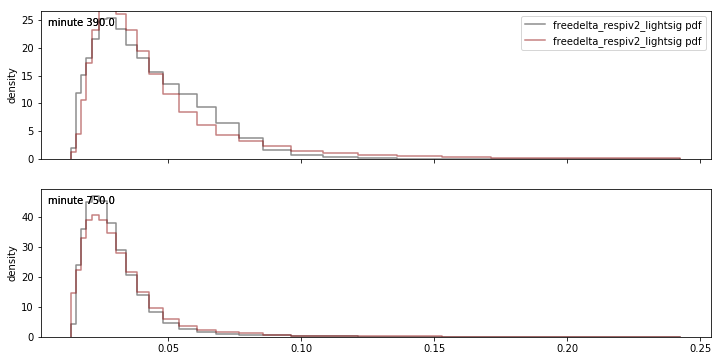

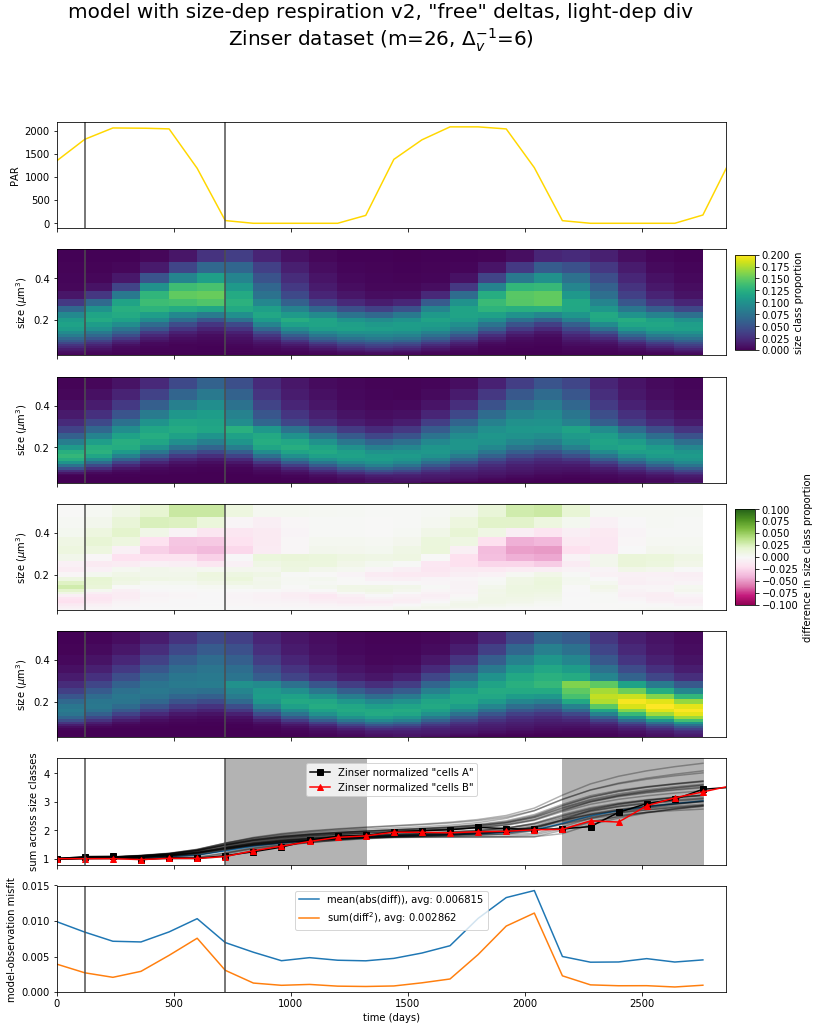

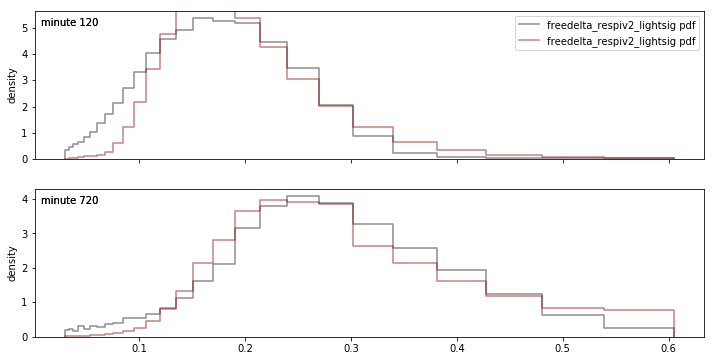

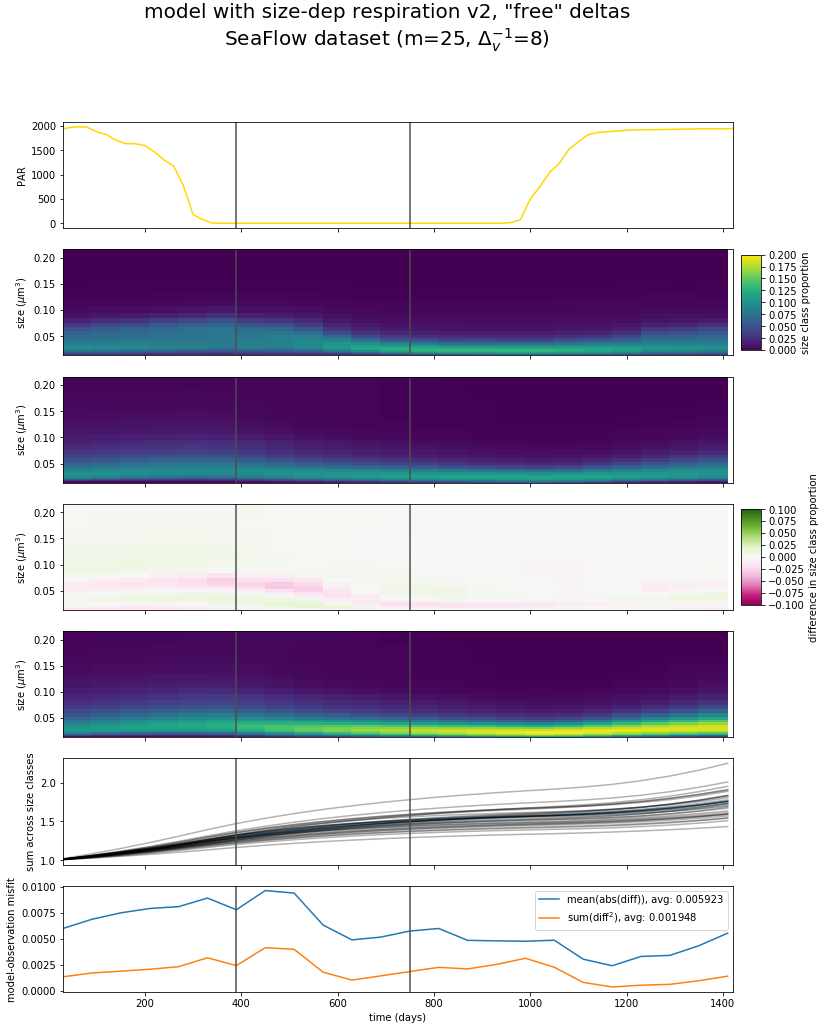

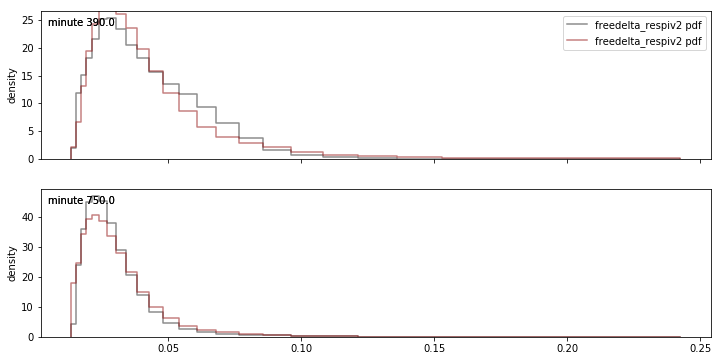

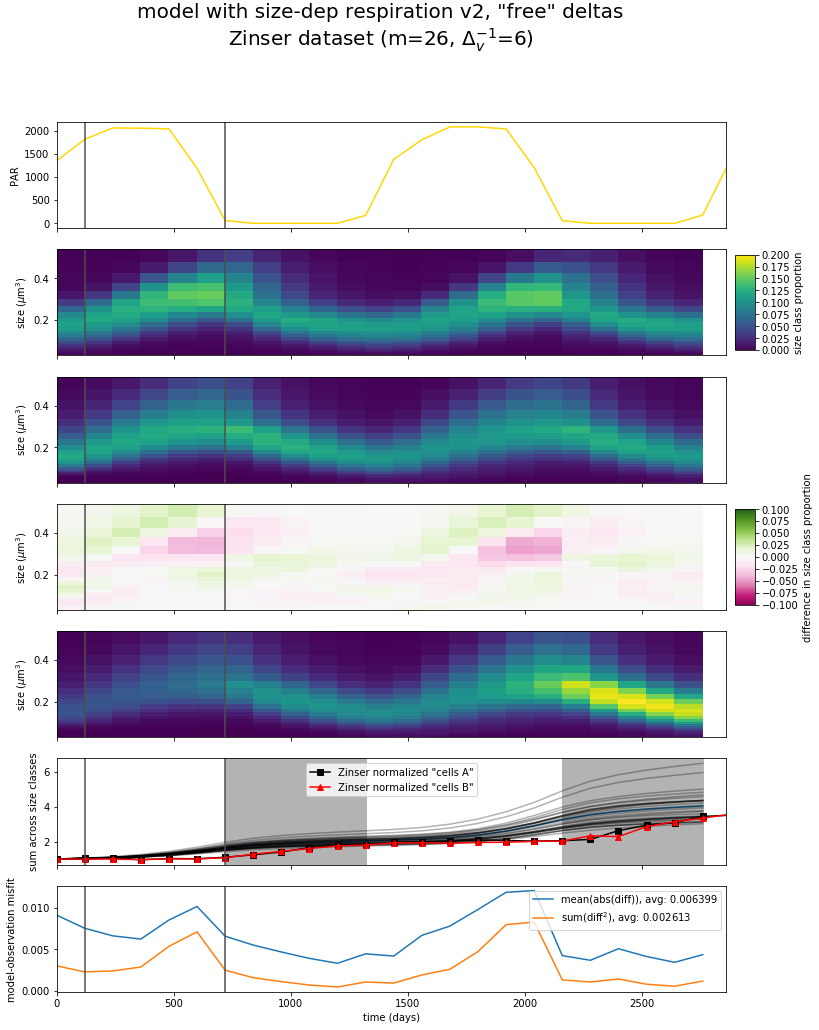

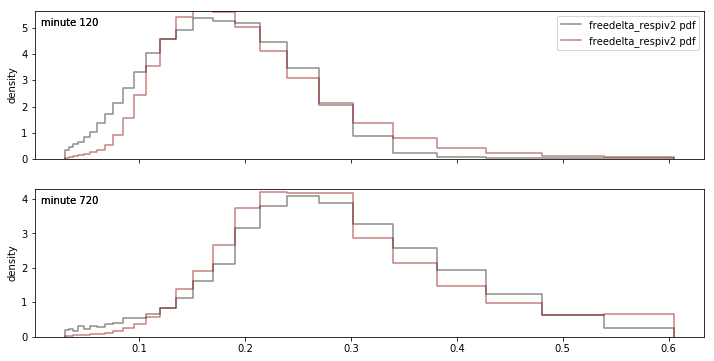

In [9]:
import pandas

data_fig2a = pandas.read_csv('data/Zinser_Figure2A.csv')

t_zinser = data_fig2a['exper time'] * 60
a_norm = data_fig2a['cells A'].copy()
a_norm /= a_norm[0]
b_norm = data_fig2a['cells B'].copy()
b_norm /= b_norm[0]

colors = {'model':'darkred', 'obs':'0.1'}

norm = mpl.colors.Normalize(0.0,0.2)
norm_diff = mpl.colors.Normalize(-0.1,0.1)

for name,mcmc in mcmcs.items():
    for k in data:
        t = data[k]['dt']*np.arange(data[k]['nt'])
        if 'zinser' in k:
            slice_indices = [1,6]
        else:
            slice_indices = [6,12]
        v_ext = data[k]['v_min'] * 2**(np.arange(data[k]['m']+1)*delta_v) 
        v = v_ext[:-1]
        v_width = v_ext[1:] - v_ext[:-1]
        
        res = {'model':np.mean(mcmc[k]['mod_obspos'], axis=0), 'obs':data[k]['obs']}
        res_sum1 = res['model']/np.sum(res['model'], axis=0)[None,:]
        diff = res_sum1-res['obs']

        fig,axs = plt.subplots(7,1,sharex=True,figsize=(12,16))
        fig.suptitle(desc_model[name] + '\n' + desc[k], size=20)

        ax = axs[0]
        ax.plot(t, data[k]['E'], color='gold')
        ax.set(xlim=(data[k]['t_obs'][0],t[-1]), ylabel='PAR')

        ax = axs[1]
        pc = ax.pcolormesh(data[k]['t_obs'],v,res['obs'],norm=norm)
        ax.set(ylabel='size ($\mu$m$^3$)')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

        ax = axs[2]
        ax.set(ylabel='size ($\mu$m$^3$)')
        pc = ax.pcolormesh(data[k]['t_obs'],v,res_sum1,norm=norm)

        ax = axs[3]
        pc = ax.pcolormesh(data[k]['t_obs'],v,diff,norm=norm_diff, cmap='PiYG')
        ax.set(ylabel='size ($\mu$m$^3$)')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='difference in size class proportion')

        ax = axs[4]
        ax.set(ylabel='size ($\mu$m$^3$)')
        pc = ax.pcolormesh(data[k]['t_obs'],v,res['model'])

        ax = axs[5]
        ax.plot(data[k]['t_obs'], np.sum(res['model'],axis=0))
        ax.plot(data[k]['t_obs'], np.sum(mcmc[k]['mod_obspos'][:30,...], axis=1).T, color='k', alpha=0.3)
        if 'zinser' in k:
            ax.plot(t_zinser, a_norm, color='black', marker='s', label='Zinser normalized "cells A"')
            ax.plot(t_zinser, b_norm, color='red', marker='^', label='Zinser normalized "cells B"')
            for iday in range(2):
                ax.axvspan(iday*24*60+12*60, iday*24*60+22*60, color='0.7', zorder=0)
            ax.legend()
        ax.set(ylabel='sum across size classes')

        ax = axs[6]
        prop = np.mean(np.abs(diff),axis=0)
        ax.plot(data[k]['t_obs'], prop, label='mean(abs(diff)), avg: {:.6f}'.format(np.mean(prop)))
        prop = np.sum(diff**2,axis=0)
        ax.plot(data[k]['t_obs'], prop, label='sum(diff$^2$), avg: {:.6f}'.format(np.mean(prop)))
        ax.set(xlabel='time (days)', ylabel='model-observation misfit')
        ax.legend()

        for ax in axs.flat:
            for i in slice_indices:
                ax.axvline(data[k]['t_obs'][i], color='.3')

        # plot slices

        plotdata_y = np.zeros(2*(data[k]['m']+1))

        fig,axs = plt.subplots(nrows=len(slice_indices), sharex=True, figsize=(12,len(slice_indices)*3))
        for i,ax in zip(slice_indices,axs.flat):
            for key in ('obs','model'):
                color = colors[key]
                cdata = res[key][:,i]
                cdata /= sum(cdata)
                plotdata_y[1:-1] = np.repeat(cdata/v_width,2)
                ax.plot(np.repeat(v_ext,2), plotdata_y, color=color, alpha=0.5, label='{} pdf'.format(name))
                ax.text(0.01, 0.95, 'minute {}'.format(data[k]['t_obs'][i]), transform=ax.transAxes, va='top', ha='left')
                ax.set_ylabel('density')
                ax.set_ylim(bottom=0.0)
        axs[0].legend()
        None

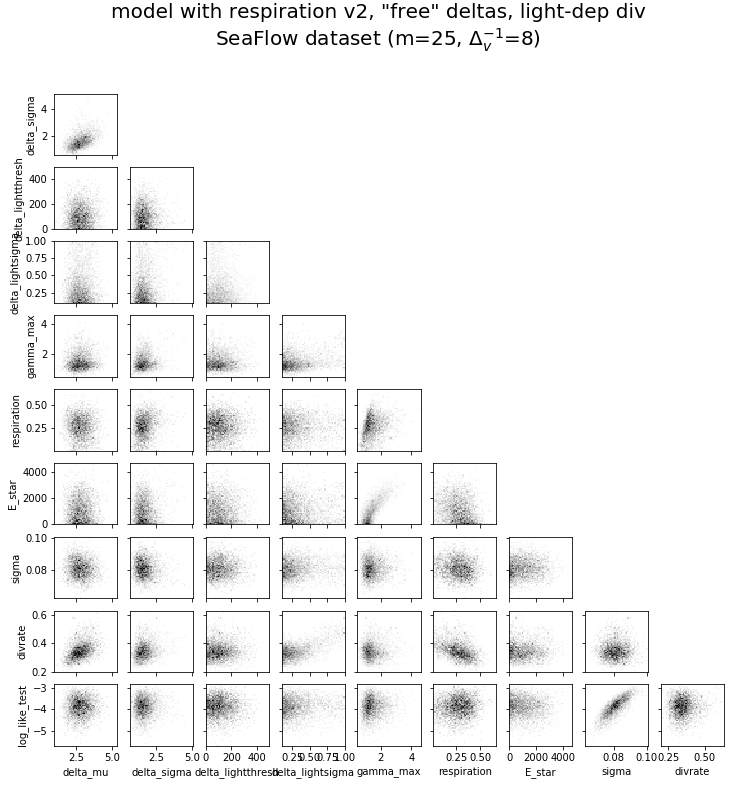

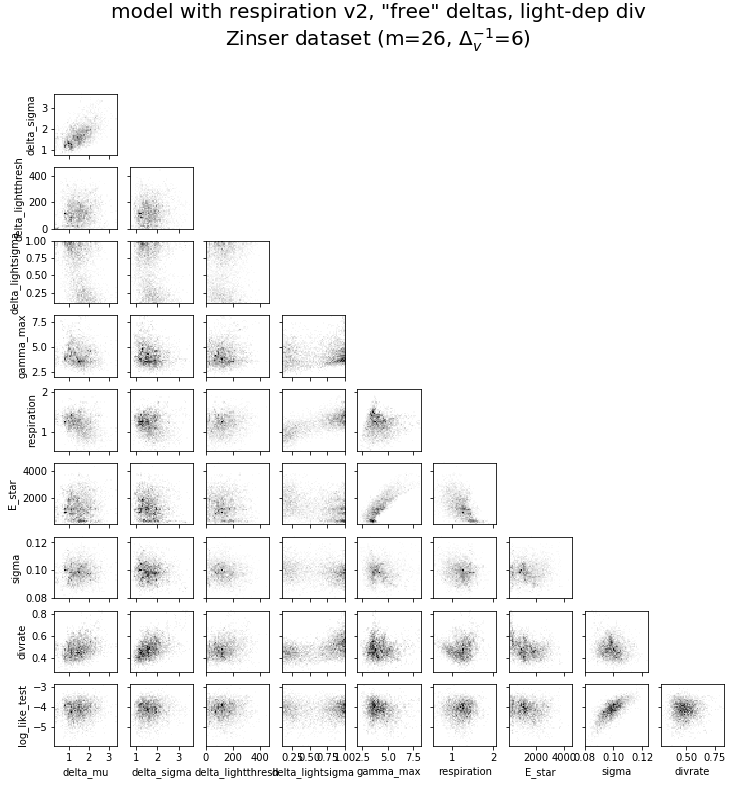

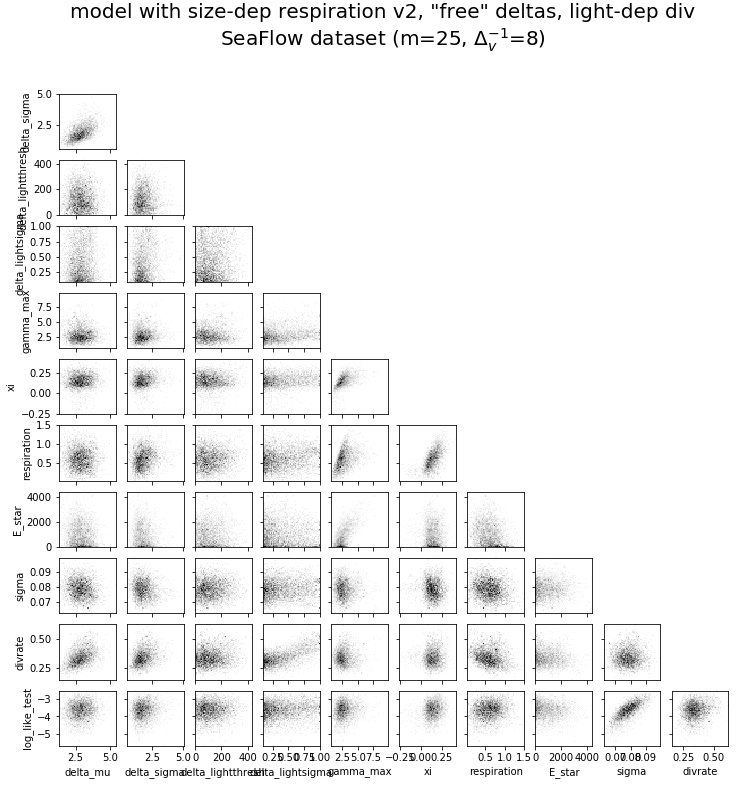

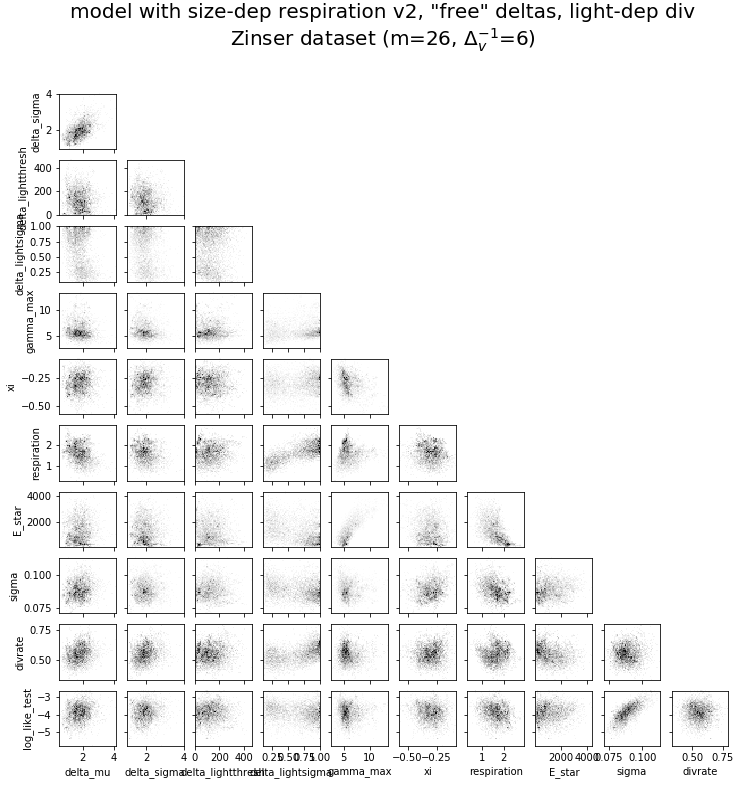

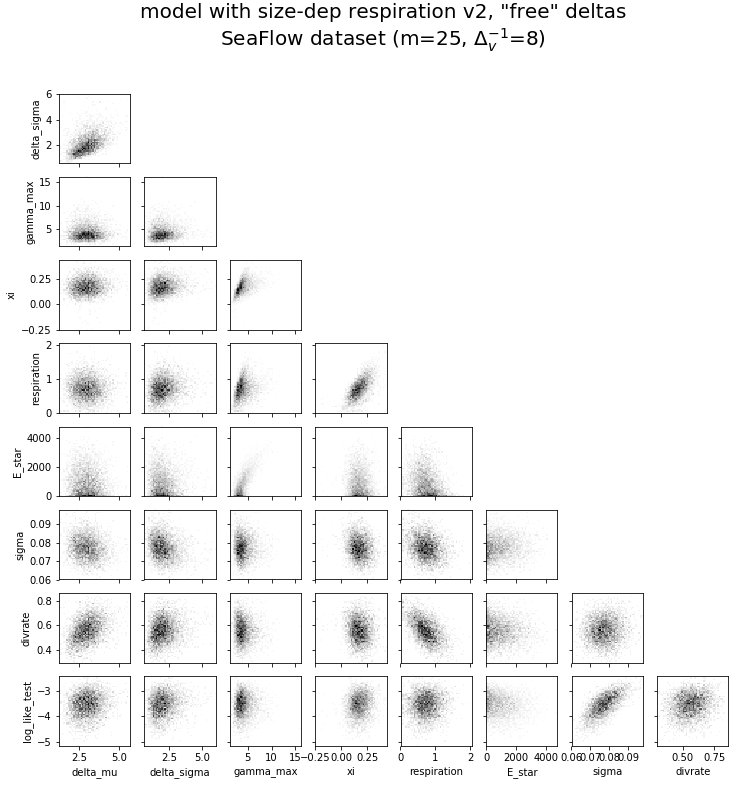

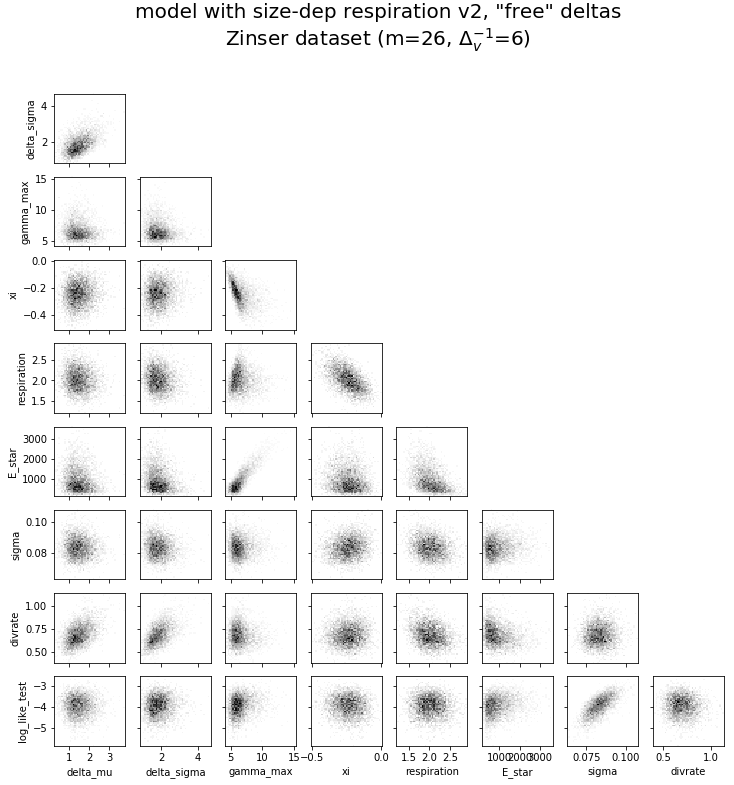

In [10]:
for name,mcmc in mcmcs.items():
    for k in data:
        paramnames = [v for v in mcmc[k].flatnames if not v.startswith('mod_obspos') 
                      and not v.startswith('delta_max') and not v.startswith('w_ini')]
        num_params = len(paramnames)

        fig,axs = plt.subplots(num_params-1,num_params-1,sharex='col',sharey='row',figsize=(12,12), squeeze=False)
        fig.suptitle(desc_model[name] + '\n' + desc[k], size=20)
        for ax in axs.flat:
            ax.set_visible(False)
        for irow in range(1,num_params):
            for icol in range(irow):
                ax = axs[irow-1,icol]
                ax.set_visible(True)
                xname = paramnames[icol]
                yname = paramnames[irow]
                ax.hist2d(mcmc[k][xname],mcmc[k][yname],bins=50,cmap=mpl.cm.gray_r)
                if icol == 0:
                    ax.set_ylabel(yname)
                if irow == num_params-1:
                    ax.set_xlabel(xname)

### error plots

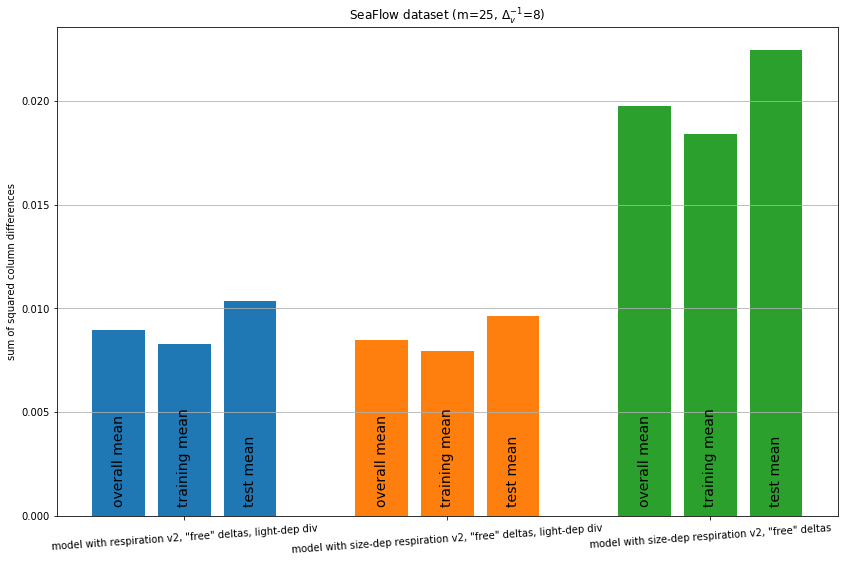

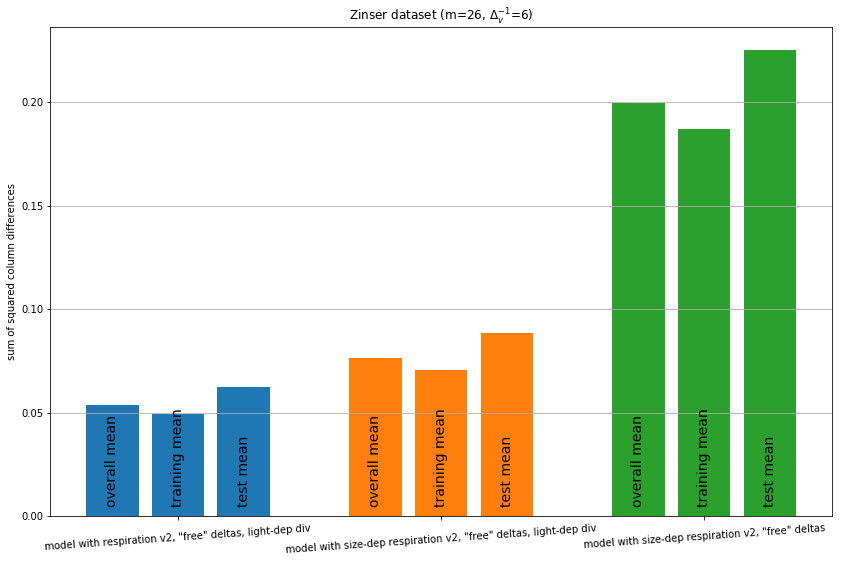

In [25]:
height = np.zeros(3)
for k in data:
    obs = data[k]['obs']
    
    fig, ax = plt.subplots(figsize=(14,9))
    xticks = []
    xticklabels = []
    for i,name in enumerate(mcmcs):
        mod_mean = np.mean(mcmcs[name][k]['mod_obspos'], axis=0)
        mod_mean /= np.sum(mod_mean, axis=0)
        
        e = np.sum((mod_mean-obs)**2,axis=0)
        
        height[0] = np.mean(e)
        height[1] = np.mean(e[data[k]['i_test'] == 0])
        height[2] = np.mean(e[data[k]['i_test'] == 1])
        
        x = 4*i+np.arange(3)
        ax.bar(x=x, height=height)
        for xx,text in zip(x,['overall mean','training mean','test mean']):
            ax.text(xx, 0, '  '+text, rotation=90, ha='center', va='bottom', size=14)
        xticks.append(x[1])
        xticklabels.append(desc_model[name])
        
    ax.set(ylabel='sum of squared column differences', xticks=xticks, title=desc[k])
    ax.set_xticklabels(xticklabels, rotation=4)
    ax.grid(axis='y')